# Code

In [23]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from plot_setup import * 
import MCgenerator, dSph_model, coord
from numpy import power,sqrt
from scipy.stats import norm

In [25]:
%autoreload 2

In [26]:
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
RA0 = draco_prop.RAdeg
DE0 = draco_prop.DEdeg
DIST = draco_prop.DIST
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [27]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
# v001: for mycut
# v002: for spectroscopy cut

## definition of likelihood

In [28]:
class KI17_loglikelihood_mod_cont:
    def __init__(self,vs,beta=1):
        self.vs = vs
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args))
    
    def is_parameters_in_domain(self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 < vfg1 < vfg2
        is_ffg_normalized_ = 0<=sfg0<=1 and 0<=sfg1<=1 and (sfg0+sfg1)<=1
        is_not_fast = np.all(np.abs(np.array([vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2]))<3e8)
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_not_fast)
    
    def loglikelis(
        self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            sfg2 = 1-sfg0-sfg1
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(ffg)

            return self.beta * ret
        
    def fit_plot(self,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1,bins=64,**kwargs):
        fig,ax = plt.subplots(1,1)
        vs=self.vs
        sfg2 = 1-sfg0-sfg1 
        ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
        ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
        ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
        ffg = ffg0+ffg1+ffg2
        df = pd.DataFrame()
        df[r"$v$"] = vs
        df["$f_{FG,0}$"] = ffg0
        df["$f_{FG,1}$"] = ffg1
        df["$f_{FG,2}$"] = ffg2
        df["$f_{FG,tot}$"] = ffg
        
        df = df.sort_values(r"$v$")
        
        ax.hist(vs,density=True,bins=bins)
        df.plot(x=r"$v$",ax=ax,**kwargs)


In [32]:
#update likelihood
def is_positive(*args):
    return np.array(args)>0

class KI17_loglikelihood_mod:
    def __init__(self,vs,dRAs,dDEs,beta=1):
        self.vs = vs
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        mem = dSph_model.plummer_model(re_pc=200)
        dm = dSph_model.NFW_model(a=2.78,b=7.78,g=0.675,rhos_Msunpc3=np.power(10,-2.05),rs_pc=np.power(10,3.96),R_trunc_pc=2000)
        self.dsph = dSph_model.dSph_model(anib=-0.5,submodels_dict={"stellar_model":mem,"DM_model":dm},show_init=True)
        
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R,show_init=True)


    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")

    def logprior(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        
        G_re = norm.pdf(re,loc=191,scale=5.7)
        #G_odds = norm.pdf(odds,loc=8.794,scale=0.5107)
        G_dra0 = norm.pdf(dra0,loc=4.212e-3,scale=7.052e-3)
        G_dde0 = norm.pdf(dde0,loc=-1.991e-3,scale=3.302e-3)
        
        return np.sum(np.log([G_re,G_dra0,G_dde0]))
    
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args)) + self.logprior(**args)
    
    def is_parameters_in_domain(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(re,odds,dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 <= vfg1 <= vfg2
        is_ffg_normalized_ = 0<=sfg0<=1 and 0<=sfg1<=1 and (sfg0+sfg1)<=1
        is_in_domain_ = -1<mlog10_1manib<1 and -4<log10_rhos_Msunpc3<4 and 0<log10_rs_pc<5 and 0.5<a<3 and 3<b<10 and 0<g<1.2
        is_not_fast = np.all(np.abs(np.array([vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2]))<3e8)
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_in_domain_ and is_not_fast)
    
    def loglikelis(
        self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(re,odds,dra0,dde0,
                log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
                mlog10_1manib,
                vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            mem,dm,fg = self.dsph.submodels["stellar_model"],self.dsph.submodels["DM_model"],self.fg
            mem.update({"re_pc":re})
            dm.update({"rs_pc":power(10,log10_rs_pc),"rhos_Msunpc3":power(10,log10_rhos_Msunpc3),"a":a,"b":b,"g":g})
            self.dsph.update({"anib":1-power(10,-mlog10_1manib)})
            ref_R = mem.half_light_radius() # 1.67834699001666*re
            
            Rs = self.Rs(dra0,dde0)
        
            s = 1/(1+ 1/(odds * mem.density_2d_normalized_re(Rs)))
            #sigmalos2 = self.dsph.sigmalos2_interp1d(Rs,step_inner=8,step_outer=16)
            #sigmalos = self.dsph.sigmalos_interp1d(Rs,step_around_Rtrunc=4,step_center=2,step_outer=16)
            sigmalos = self.dsph.sigmalos_dequad(Rs)
            sfg2 = 1-sfg0-sfg1
            
            fmem = norm.pdf(vs,loc=vmem,scale=sigmalos)
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(s*fmem+(1-s)*ffg)

            return self.beta * ret


Text(0,0.5,'$y$[deg]')

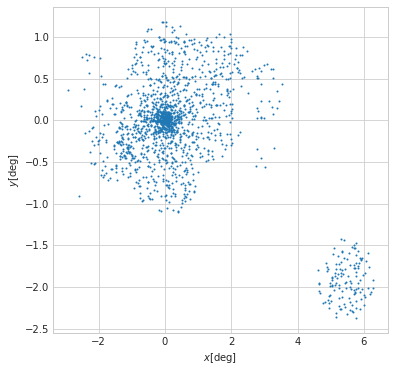

In [33]:
df0 = pd.read_csv("dra_sspp2_RADEdeg.csv")
#display(df0)
df_deg = pd.DataFrame(df0[["RAdeg","DEdeg"]])
df_rad = np.deg2rad(pd.DataFrame(df_deg))

df_deg["x"] = df_deg["RAdeg"] - RA0
df_deg["y"] = df_deg["DEdeg"] - DE0

#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.RAdeg
de = df_deg.DEdeg
vs = df0.Vlos

arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":RA0,"de_center":DE0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=DIST,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 4
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))
plt.xlabel(r"$x$[deg]")
plt.ylabel(r"$y$[deg]")

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1b2e7c24a8>]],
      dtype=object)

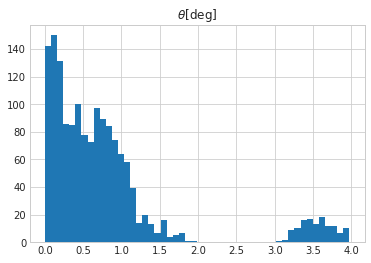

In [34]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09a9b64f60>]],
      dtype=object)

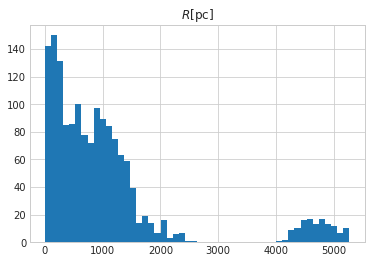

In [10]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

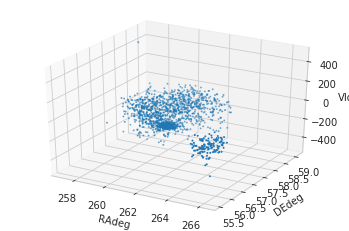

In [11]:
df0[["RAdeg","DEdeg","Vlos"]].plot_scatter3D("RAdeg","DEdeg","Vlos",s=1)

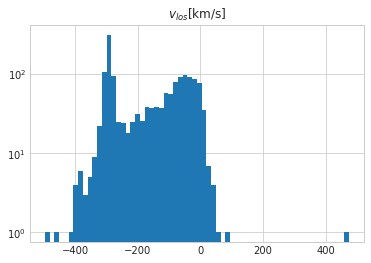

In [12]:
df_vlos = pd.DataFrame({r"$v_{los}$[km/s]":df0.Vlos.values})
df_vlos.hist(bins=64)
len(df0)
plt.yscale("log")

[429, 730, 843]

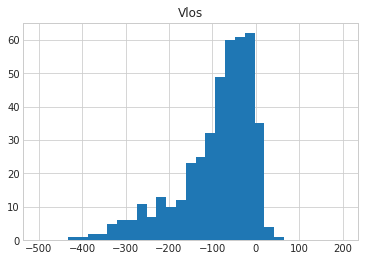

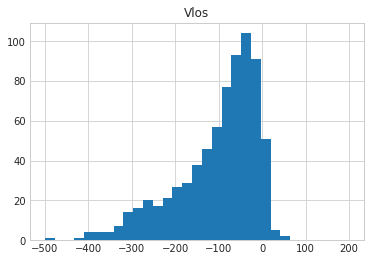

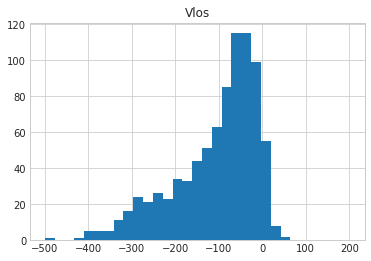

In [47]:
df_plot = df0[Rs>900]
bins = np.linspace(-500,200,32)
df0[Rs>1190].hist("Vlos",bins=bins)
df0[Rs>830].hist("Vlos",bins=bins)
df0[Rs>670].hist("Vlos",bins=bins)

display([len(df0[Rs>1190]),len(df0[Rs>830]),len(df0[Rs>670])])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f09a93a7f60>]],
      dtype=object)

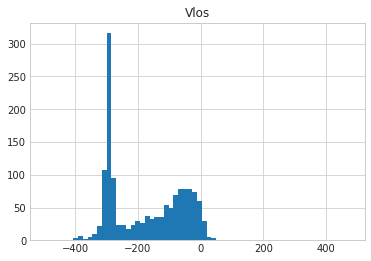

In [14]:
df0[angles<2.5].hist("Vlos",bins=64)

## likelihood compile

In [35]:
isin_sig = Rs<3000 #670(92.5%), 830(95%), 1190(97.5%) 1900(99%), 3000
loglikeli_cont =  KI17_loglikelihood_mod_cont(vs=vs[np.logical_not(isin_sig)])
loglikeli = KI17_loglikelihood_mod(vs=vs[isin_sig],dRAs=df_deg.x[isin_sig],dDEs=df_deg.y[isin_sig])
#sigmalos2 = loglikeli.dsph.sigmalos2_using_mykernel(loglikeli.Rs(0,0))
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

initialized:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64
initialized:
Rmax_pc    2531.745788
dtype: float64


CPU times: user 1.4 s, sys: 0 ns, total: 1.4 s
Wall time: 1.4 s


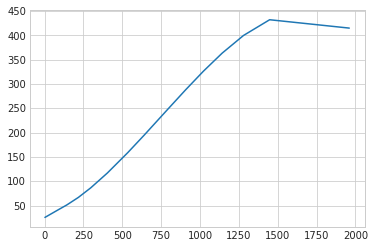

In [16]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::100]
ys0 = loglikeli.dsph.sigmalos2(R_pc)
plt.plot(R_pc,ys0)

: Plummer model and NFW model:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64

2000.0

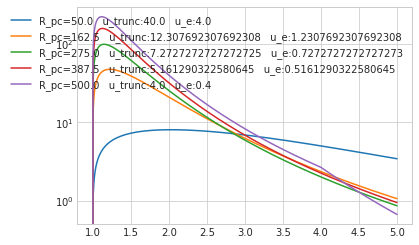

In [17]:
display(loglikeli.dsph)
us = np.linspace(1,5,1000)
for R_pc in np.linspace(50,500,5):#,100,200,1000,2000,3000,4000):
    ys = loglikeli.dsph.integrand_sigmalos2_using_mykernel(arg_R_pc=R_pc,u=us)
    R_trunc_pc= loglikeli.dsph.submodels["DM_model"].params.R_trunc_pc
    re_pc= loglikeli.dsph.submodels["stellar_model"].params.re_pc
    plt.plot(us,ys,label="R_pc="+str(R_pc)+"   u_trunc:"+str(R_trunc_pc/R_pc)+"   u_e:"+str(re_pc/R_pc))
    #display(ys)
plt.legend()
plt.xscale("linear")
plt.yscale("log")
display(R_trunc_pc)

CPU times: user 1.14 s, sys: 0 ns, total: 1.14 s
Wall time: 1.14 s


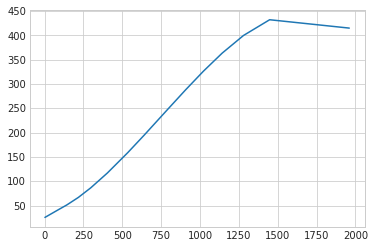

In [18]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::100]
ys1 = loglikeli.dsph.sigmalos2_using_mykernel(R_pc)
plt.plot(R_pc,ys1)

CPU times: user 28 ms, sys: 32 ms, total: 60 ms
Wall time: 8.51 s


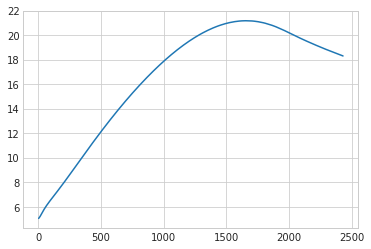

In [19]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::4]
ys0 = sqrt(loglikeli.dsph.sigmalos2_multi_using_mykernel(R_pc))
plt.plot(R_pc,(ys0))
plt.xscale("linear")

CPU times: user 20 ms, sys: 36 ms, total: 56 ms
Wall time: 545 ms


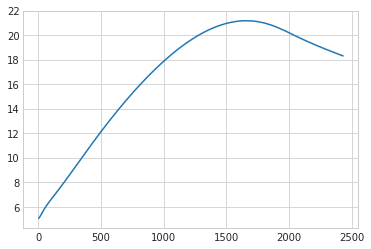

In [20]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::4]
ys1 = loglikeli.dsph.sigmalos_interp1d(R_pc,step_around_Rtrunc=4,step_center=2,step_outer=16)
plt.plot(R_pc,ys1)
plt.xscale("linear")

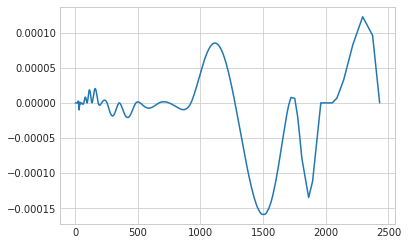

In [21]:
plt.plot(R_pc,(np.array(ys1)-np.array(ys0))/np.array(ys0))
min(R_pc)
plt.xscale("linear")

# MCMC

## Cont

In [168]:
gen_cont = MCgenerator.MCgenerator(
    args_logpdf_init={
        "vfg0": -152.939605,
        "vfg1": -43.608103,
        "vfg2": -4.512821,
        "dvfg0": 80.441576,
        "dvfg1": 33.495326,
        "dvfg2": 0.490637,
        "sfg0":  0.183776,
        "sfg1":  0.773582},
#    args_logpdf_init={
#        'vfg0':-136, 'vfg1':-46, 'vfg2':-5, 'dvfg0':93, 'dvfg1':32,'dvfg2':0.6,
#        'sfg0':0.25,'sfg1':0.66
#    },
    dargs_logpdf={
        'vfg0':30, 'vfg1':8, 'vfg2':0.001, 'dvfg0':15, 'dvfg1':6,'dvfg2':0.001,
        'sfg0':0.05,'sfg1':0.05
    },
    logpdf_func=loglikeli_cont
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
update dargs_logpdf:
before:
{}
after:
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
dtype: float64
MCparameters are initialized.


In [246]:
loglikeli_cont(**{
        'vfg0':-4e8, 'vfg1':-200, 'vfg2':-0, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.01,'sfg1':0.2
    })

TypeError: loglikelis() got an unexpected keyword argument 'kwargs'

In [169]:
Nstep_init = 10000
gen_cont.generate(Nstep_init)

MCgeneration start.
options: {}
MCgeneration end.
MCresults are stored.
MCinfo are logged.
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
dtype: float64


In [171]:
#gen_cont.generate(100000)
gen_cont.generate_tuned([100000]*10)

MCgeneration start.
options: {}
25.572% completed... acceptance rate: 1.13%
51.058% completed... acceptance rate: 1.15%
76.339% completed... acceptance rate: 1.20%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
dtype: float64
0th itetation
update dargs_logpdf:
before:
vfg0     30.000
vfg1      8.000
vfg2      0.001
dvfg0    15.000
dvfg1     6.000
dvfg2     0.001
sfg0      0.050
sfg1      0.050
dtype: float64
after:
vfg0     11.082646
vfg1      3.143810
vfg2      0.009151
dvfg0     6.045722
dvfg1     2.583704
dvfg2     0.007146
sfg0      0.040028
sfg1      0.040266
dtype: float64
MCgeneration start.
options: {}
24.292% completed... acceptance rate: 7.52%
49.013% completed... acceptance rate: 7.33%
73.629% completed... accep

41.909% completed... acceptance rate: 17.65%
63.499% completed... acceptance rate: 17.65%
84.604% completed... acceptance rate: 17.93%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
vfg0       30.000000
vfg1        8.000000
vfg2        0.001000
dvfg0      15.000000
dvfg1       6.000000
dvfg2       0.001000
sfg0        0.050000
sfg1        0.050000
vfg0       30.000000
vfg1        8.000000
vfg2        0.001000
dvfg0      15.000000
dvfg1       6.000000
dvfg2       0.001000
sfg0        0.050000
sfg1        0.050000
vfg0       11.082646
vfg1        3.143810
vfg2        0.009151
dvfg0       6.045722
dvfg1       2.583704
dvfg2       0.007146
sfg0        0.040028
sfg1        0.040266
vfg0       10.655807
vfg1        3.171886
vfg2        0.148470
dvfg0       5.794971
dvfg1       2.374150
dvfg2       0.080654
            ...     
vfg2        1.886307
dvfg0       6.017851
dvfg1       3.217763
dvfg2       2.440693
sfg0        0.040906
sfg1        0.052383
vfg0       87.197275
vfg1    

,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2,sfg0,sfg1,logpdf
count,110001.000000,110001.000000,110001.000000,110001.000000,110001.000000,110001.000000,110001.000000,110001.000000,110001.000000
mean,-229.473625,-121.120938,-35.081015,242.877461,61.150047,32.811877,0.222684,0.355234,-4239.578306
std,86.454695,50.282300,10.201862,249.695326,24.374920,3.771199,0.179461,0.078903,3.941200
min,-699.672626,-227.528058,-58.917818,80.441576,18.567506,26.094457,0.000019,0.046811,-4253.886719
25%,-247.917110,-176.221505,-45.523211,103.644798,40.002438,30.011885,0.009408,0.307497,-4242.545576
50%,-192.819533,-92.415760,-32.768239,110.389635,46.390933,30.044599,0.324949,0.364358,-4240.724635
75%,-180.706824,-76.918155,-25.027340,283.147122,88.347013,36.441131,0.377920,0.413810,-4235.623837
max,-146.178116,-43.480636,-24.901035,1863.004560,110.492000,46.401093,0.532089,0.583880,-4231.464773


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcedb4a8080>,
      dtype=object)

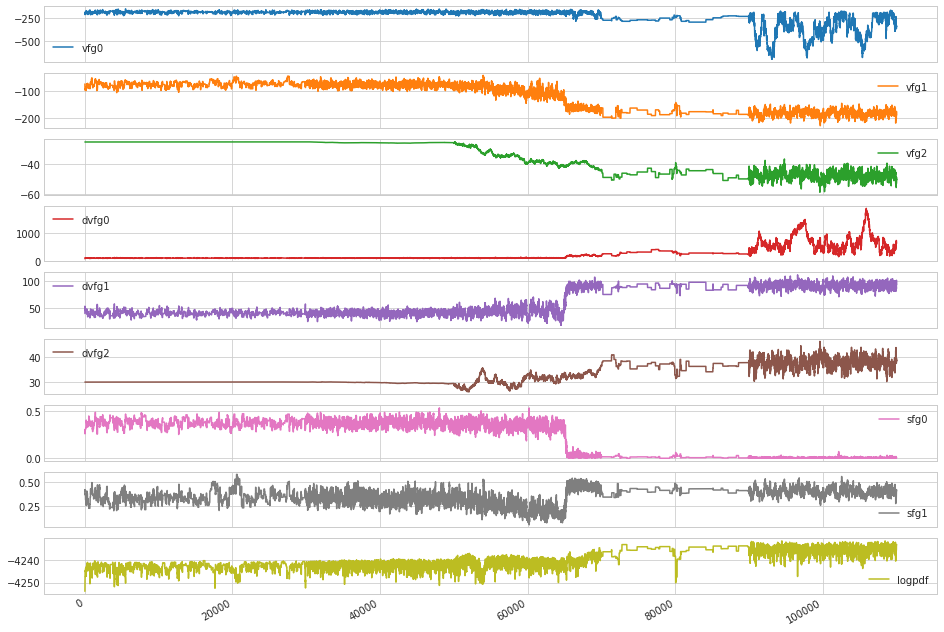

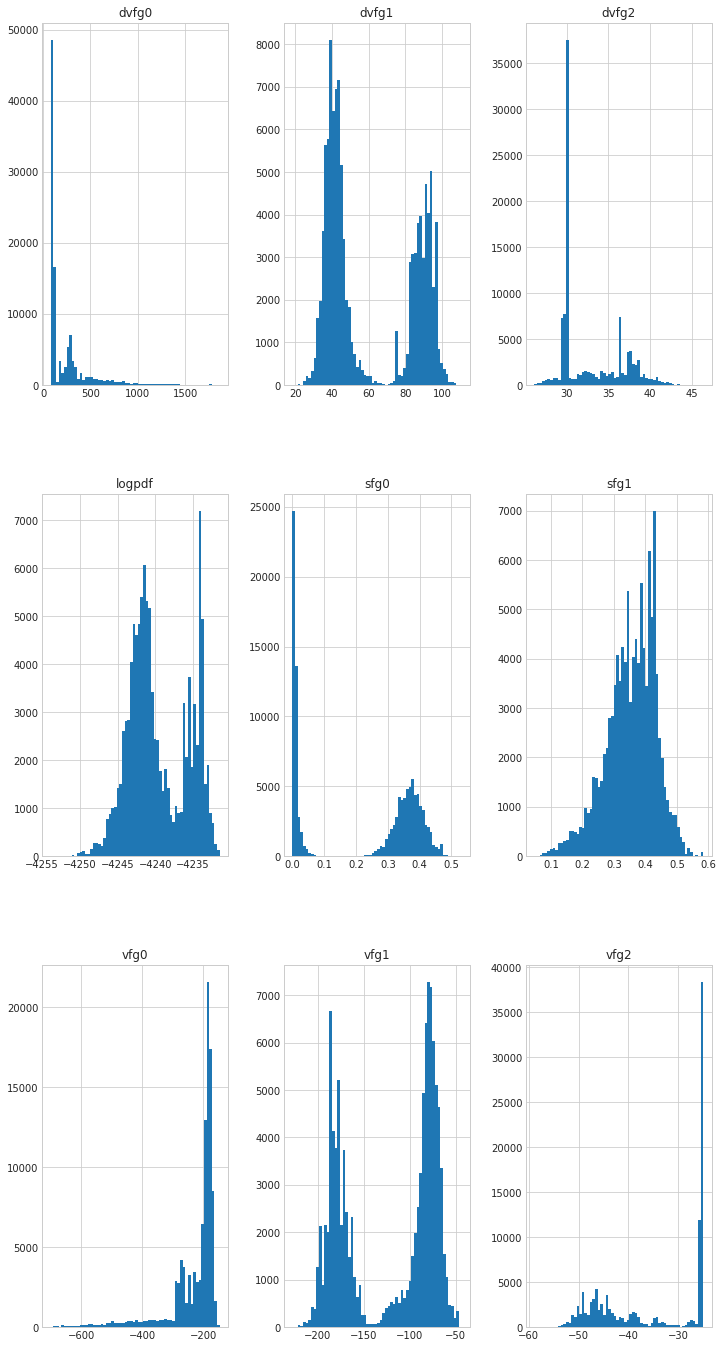

In [48]:
display(gen_cont.to_DataFrame()[:].describe())
gen_cont.to_DataFrame()[:].plot(subplots=True,figsize=(16,12))
gen_cont.to_DataFrame()[:].hist(bins=64,figsize=(12,24))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f198f84d828>,
      dtype=object)

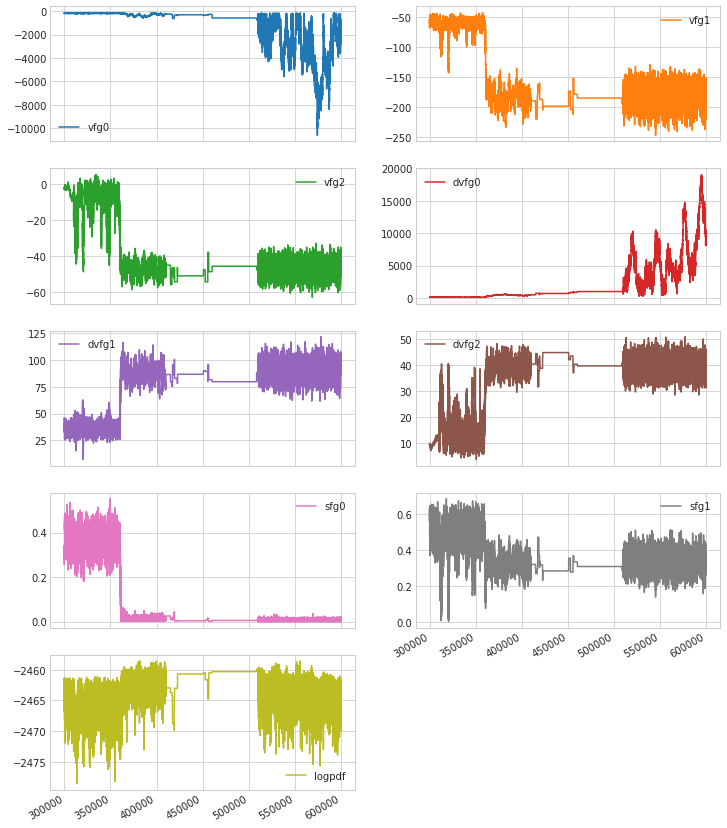

In [174]:
gen_cont.to_DataFrame()[300000:600000].plot(subplots=True,figsize=(12,16),layout=(5,2))

In [175]:
argmax_full = gen_cont.to_DataFrame().sort_values(by="logpdf").iloc[-1]
argmax_last = gen_cont.to_DataFrame()[-100000:].sort_values(by="logpdf").iloc[-1]
display(argmax_full)
display(argmax_last)
argmax_2gaussian = argmax_last.copy()
argmax_2gaussian.sfg0 = 0
logpdf_2gaussian = loglikeli_cont(**argmax_2gaussian[:-1])
display(logpdf_2gaussian)
display(logpdf_2gaussian-argmax_2gaussian.logpdf)

vfg0      -315.324466
vfg1      -181.495866
vfg2       -46.258455
dvfg0      539.338345
dvfg1       88.116720
dvfg2       38.665301
sfg0         0.002410
sfg1         0.335297
logpdf   -2458.540754
Name: 382014, dtype: float64

vfg0     -2.109136e+06
vfg1     -1.821582e+02
vfg2     -4.670919e+01
dvfg0     3.646009e+06
dvfg1     8.401631e+01
dvfg2     3.878459e+01
sfg0      4.564480e-03
sfg1      3.206547e-01
logpdf   -2.467503e+03
Name: 982155, dtype: float64

-2481.0262941472038

-13.523649238140933

vfg0    -315.324466
vfg1    -181.495866
vfg2     -46.258455
dvfg0    539.338345
dvfg1     88.116720
dvfg2     38.665301
sfg0       0.002410
sfg1       0.335297
Name: 382014, dtype: float64

(-400, 50)

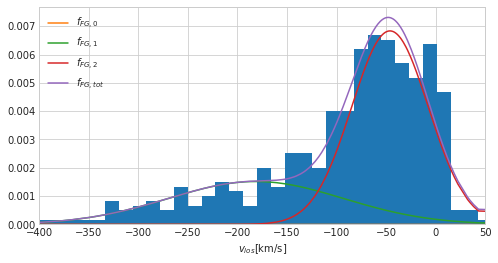

In [176]:
argmax_ = argmax_full[argmax_full.index[:-1]]
display(argmax_)
loglikeli_cont.fit_plot(**argmax_,figsize=(8,4))
plt.xlabel(r"$v_{los}$[km/s]")
plt.xlim((-400,50))

vfg0    -6.907239e+05
vfg1    -1.840974e+02
vfg2    -4.949531e+01
dvfg0    2.246518e+06
dvfg1    8.959726e+01
dvfg2    3.967549e+01
sfg0     8.780452e-04
sfg1     3.773287e-01
Name: 1034323, dtype: float64

(-400, 50)

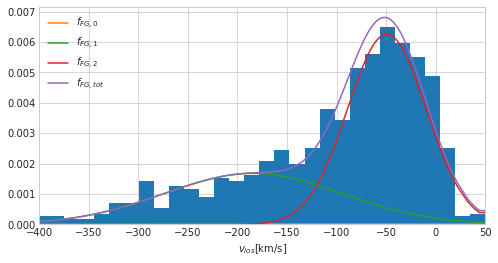

In [419]:
argmax_ = argmax_last[argmax_last.index[:-1]]
display(argmax_)
loglikeli_cont.fit_plot(**argmax_,figsize=(8,4))
plt.xlabel(r"$v_{los}$[km/s]")
plt.xlim((-400,50))

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

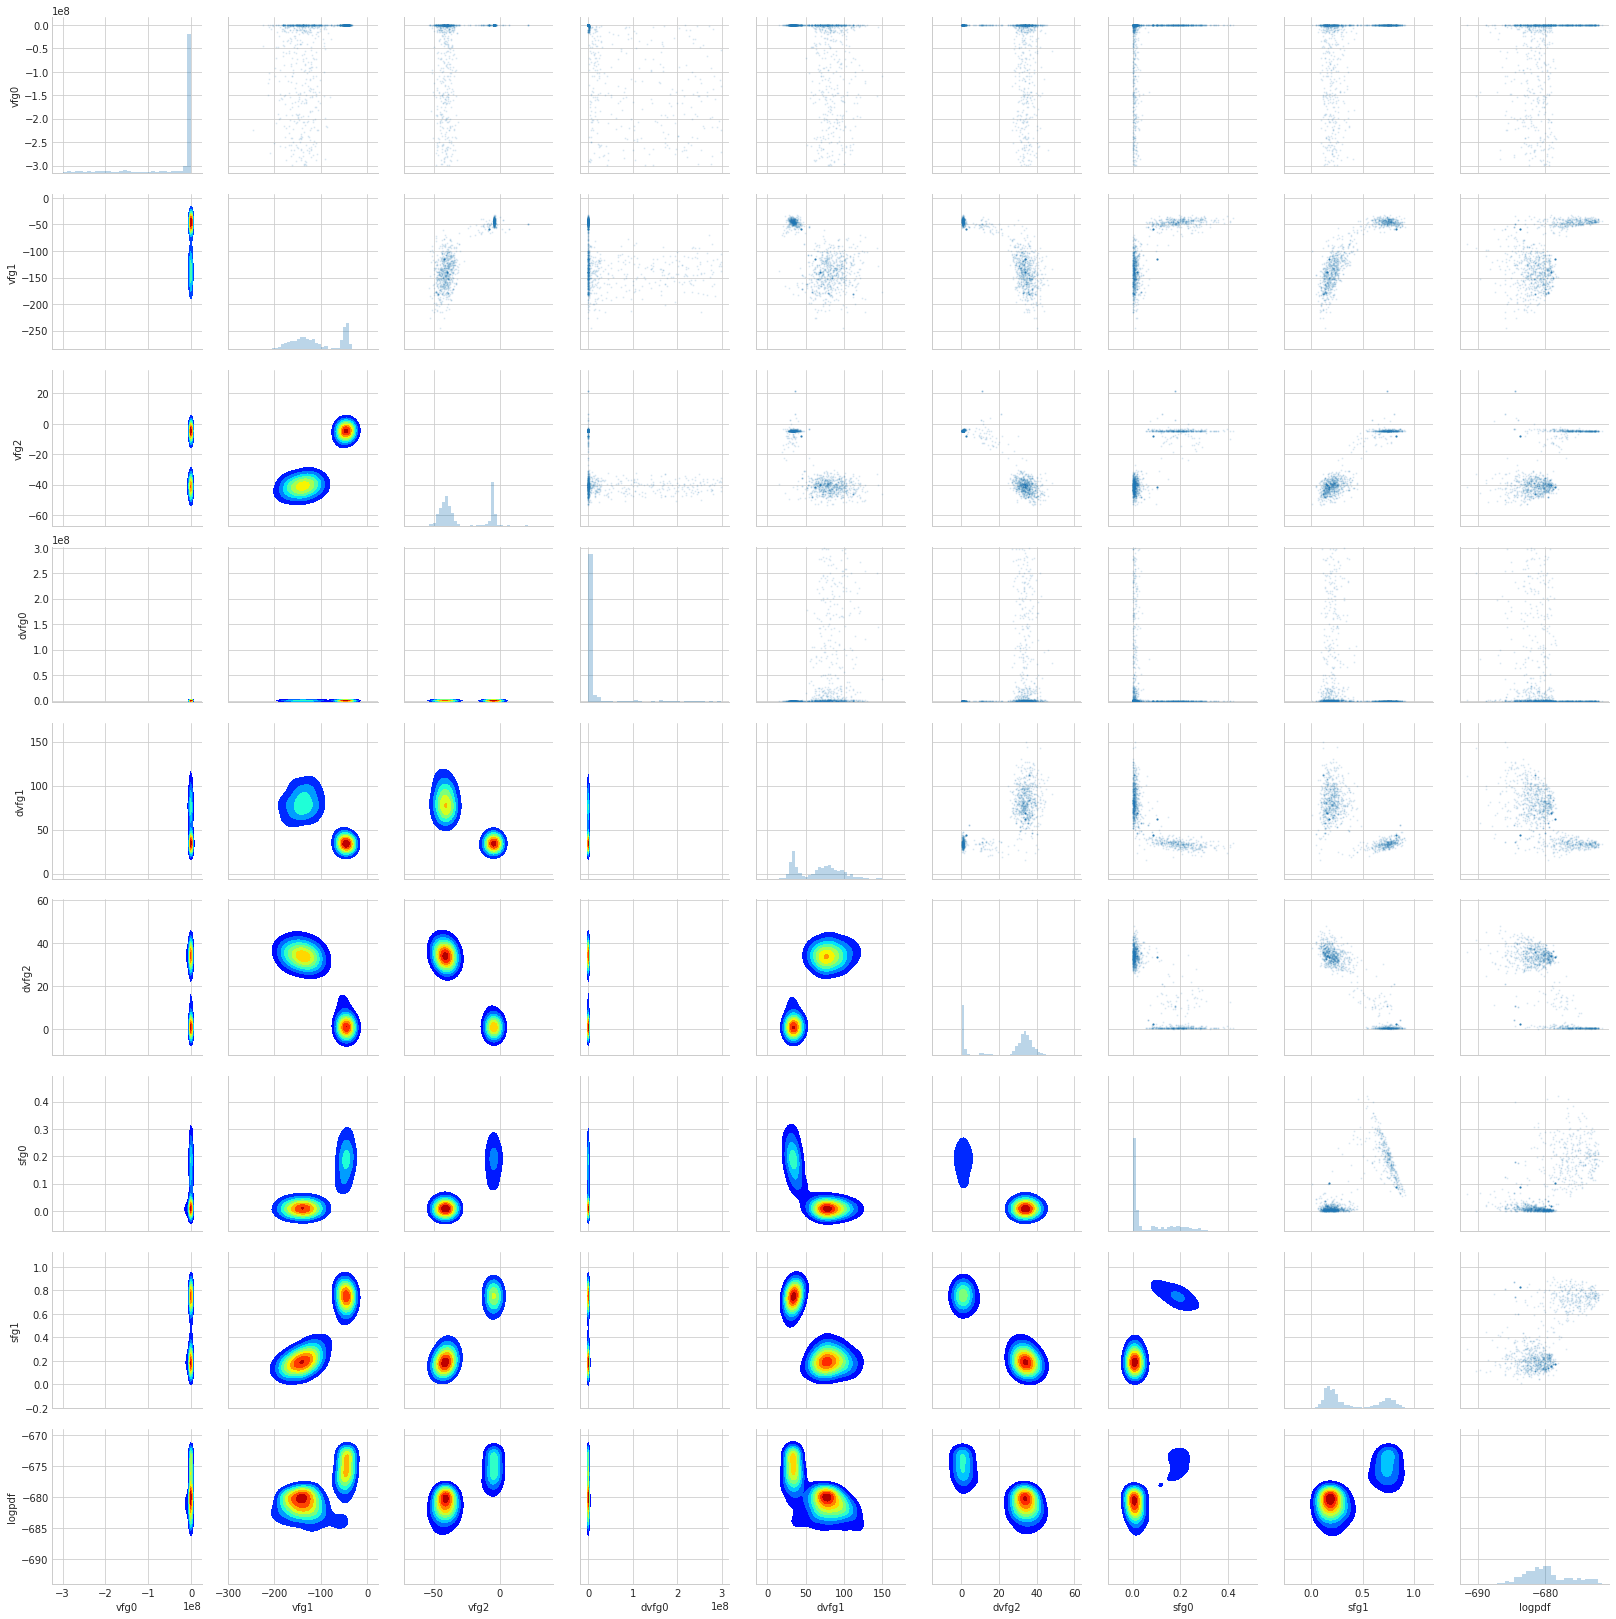

In [310]:
mypairplot(gen_cont.to_DataFrame()[::1000])

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


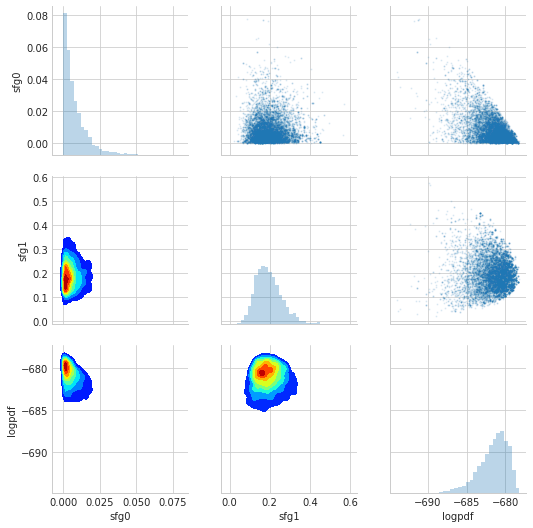

In [374]:
mypairplot(gen_cont.to_DataFrame()[-100000:][["sfg0","sfg1","logpdf"]][::10])

In [386]:
beta = 1/np.log(len(loglikeli_cont.vs))
display(1/beta)
bic_ = -gen_cont.to_DataFrame()["logpdf"].max() + (len(gen_cont.to_DataFrame().columns)-1)/2/beta
bic_

5.123963979403259

940.4712482227638

In [387]:
beta = 1/np.log(len(loglikeli_cont.vs))
bic_ = -logpdf_2gaussian + (3*2-1)/2/beta
bic_

940.3538598478767

In [177]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-1190pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
gen_cont.to_csv(FNAME_BASE.format("",SPECIFY_NAME,VERSION))
gen_cont.to_csv(FNAME_BASE.format("log",SPECIFY_NAME,VERSION),output_log=True)

## Sig

count    1438.000000
mean      739.421542
std       530.950425
min         1.677323
25%       261.901134
50%       666.381942
75%      1118.380581
max      2531.745788
dtype: float64

array([ 5.7909843 ,  7.44823522,  6.23659907, ..., 17.48104667,
       17.16406962, 16.51556016])

1438

CPU times: user 556 ms, sys: 52 ms, total: 608 ms
Wall time: 605 ms


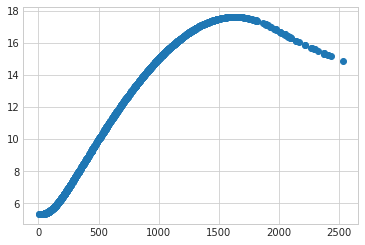

In [51]:
%%time
display(loglikeli.Rs(0,0).describe())
'''
lnl = loglikeli(**{
        "re":200, "odds":6.5,"dra0":0.0,"dde0":0.0,
        "log10_rs_pc":4, 'log10_rhos_Msunpc3':-2., 'a':2.5, 'b':7., 'g':0.5, 'mlog10_1manib':0., 
        'vmem':-200, 'vfg0':-250, 'vfg1':-200, 'vfg2':-50, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.3,'sfg1':0.3
    })
'''
#display(lnl)
Rs_tmp = loglikeli.Rs(dde0=0,dra0=0)
sigmalos_tmp = loglikeli.dsph.sigmalos_dequad(R_pc=Rs_tmp)
display(sigmalos_tmp,np.logical_not(np.isnan(sigmalos_tmp)).sum())
plt.scatter(Rs_tmp,sigmalos_tmp)

In [52]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={
 're': 199.28948352120963,
 'odds': 6.110482888180316,
 'dra0': 0.0027107145314206734,
 'dde0': 0.0019431916651246623,
 'log10_rs_pc': 4.61975696265689,
 'log10_rhos_Msunpc3': -2.768076282085142,
 'a': 1.824565306381402,
 'b': 8.478360213945722,
 'g': 0.8232316601071609,
 'mlog10_1manib': 0.10177658300317267,
 'vmem': -292.49186903873334,
 'vfg0': -2263834.1414957047,
 'vfg1': -182.05556974993627,
 'vfg2': -47.587911525642625,
 'dvfg0': 39014865.57475361,
 'dvfg1': 88.55010138144186,
 'dvfg2': 37.47682110572142,
 'sfg0': 0.0030915722406646825,
 'sfg1': 0.4832156433922633
    },
    dargs_logpdf={
        "re":0.1,"odds":0.1,"dra0":0.001,"dde0":0.001,
        "log10_rs_pc":0.05,'log10_rhos_Msunpc3':0.05, 'a':0.05, 'b':0.05, 'g':0.05, 'mlog10_1manib':0.05, 
        'vmem':0.1, 'vfg0':1e7, 'vfg1':1.0, 'vfg2':1, 'dvfg0':1e7, 'dvfg1':2,'dvfg2':1,
        'sfg0':1e-4,'sfg1':0.02
    },
    logpdf_func=loglikeli,
    print_func=display
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
update dargs_logpdf:
before:


{}

after:


re                    1.000000e-01
odds                  1.000000e-01
dra0                  1.000000e-03
dde0                  1.000000e-03
log10_rs_pc           5.000000e-02
log10_rhos_Msunpc3    5.000000e-02
a                     5.000000e-02
b                     5.000000e-02
g                     5.000000e-02
mlog10_1manib         5.000000e-02
vmem                  1.000000e-01
vfg0                  1.000000e+07
vfg1                  1.000000e+00
vfg2                  1.000000e+00
dvfg0                 1.000000e+07
dvfg1                 2.000000e+00
dvfg2                 1.000000e+00
sfg0                  1.000000e-04
sfg1                  2.000000e-02
dtype: float64

MCparameters are initialized.


In [53]:
display(gen)

           re      odds      dra0      dde0  log10_rs_pc  log10_rhos_Msunpc3  \
0  199.289484  6.110483  0.002711  0.001943     4.619757           -2.768076   

          a        b         g  mlog10_1manib        vmem          vfg0  \
0  1.824565  8.47836  0.823232       0.101777 -292.491869 -2.263834e+06   

        vfg1       vfg2         dvfg0      dvfg1      dvfg2      sfg0  \
0 -182.05557 -47.587912  3.901487e+07  88.550101  37.476821  0.003092   

       sfg1       logpdf  
0  0.483216 -7639.294282  

In [196]:
Nstep_init = 2000
gen.generate(Nstep_init)

MCgeneration start.
options: {}
0.850% completed... acceptance rate: 11.76%
2.150% completed... acceptance rate: 6.98%
2.700% completed... acceptance rate: 9.26%
3.450% completed... acceptance rate: 10.14%
4.000% completed... acceptance rate: 11.25%
4.900% completed... acceptance rate: 9.18%
5.700% completed... acceptance rate: 7.89%
6.500% completed... acceptance rate: 6.92%
7.550% completed... acceptance rate: 6.62%
8.300% completed... acceptance rate: 6.02%
8.900% completed... acceptance rate: 6.74%
9.450% completed... acceptance rate: 6.35%
10.100% completed... acceptance rate: 8.42%
11.200% completed... acceptance rate: 8.04%
12.300% completed... acceptance rate: 7.72%
13.450% completed... acceptance rate: 7.43%
14.050% completed... acceptance rate: 8.19%
14.750% completed... acceptance rate: 8.14%
16.150% completed... acceptance rate: 7.74%
17.650% completed... acceptance rate: 7.37%
18.600% completed... acceptance rate: 7.26%
19.500% completed... acceptance rate: 7.18%
20.250% c

re                    1.000000e-01
odds                  1.000000e-01
dra0                  1.000000e-03
dde0                  1.000000e-03
log10_rs_pc           5.000000e-02
log10_rhos_Msunpc3    5.000000e-02
a                     5.000000e-02
b                     5.000000e-02
g                     5.000000e-02
mlog10_1manib         5.000000e-02
vmem                  1.000000e-01
vfg0                  1.000000e+07
vfg1                  1.000000e+00
vfg2                  1.000000e+00
dvfg0                 1.000000e+07
dvfg1                 2.000000e+00
dvfg2                 1.000000e+00
sfg0                  1.000000e-04
sfg1                  2.000000e-02
dtype: float64

In [ ]:
df = gen.to_DataFrame()
df.plot(subplots=True,figsize=(8,12),layout=(8,3))
display(gen.to_DataFrame(output_log=True))
display(df.describe())
display(df.logpdf.idxmax())
display(df.iloc[df.logpdf.idxmax()].to_dict())
#display(mypairplot(df[-2000:]))

In [ ]:
%%time
gen.generate_tuned([20000,20000,200000],proposal_dist="multivariate_normal")

MCgeneration start.
options: {}
0.065% completed... acceptance rate: 23.08%
0.125% completed... acceptance rate: 24.00%
0.195% completed... acceptance rate: 20.51%
0.295% completed... acceptance rate: 18.64%
0.395% completed... acceptance rate: 18.99%
0.495% completed... acceptance rate: 19.19%
0.550% completed... acceptance rate: 19.09%
0.615% completed... acceptance rate: 20.33%
0.670% completed... acceptance rate: 20.15%
0.725% completed... acceptance rate: 19.31%
0.780% completed... acceptance rate: 18.59%
0.835% completed... acceptance rate: 19.16%
0.890% completed... acceptance rate: 18.54%
0.945% completed... acceptance rate: 18.52%
1.005% completed... acceptance rate: 19.40%
1.060% completed... acceptance rate: 19.34%
1.130% completed... acceptance rate: 19.03%
1.205% completed... acceptance rate: 18.67%
1.260% completed... acceptance rate: 19.05%
1.315% completed... acceptance rate: 18.25%
1.370% completed... acceptance rate: 18.98%
1.425% completed... acceptance rate: 18.95%


10.915% completed... acceptance rate: 18.64%
10.970% completed... acceptance rate: 18.78%
11.025% completed... acceptance rate: 18.68%
11.080% completed... acceptance rate: 18.68%
11.135% completed... acceptance rate: 18.63%
11.190% completed... acceptance rate: 18.54%
11.240% completed... acceptance rate: 18.55%
11.295% completed... acceptance rate: 18.46%
11.350% completed... acceptance rate: 18.55%
11.405% completed... acceptance rate: 18.63%
11.460% completed... acceptance rate: 18.67%
11.515% completed... acceptance rate: 18.63%
11.570% completed... acceptance rate: 18.71%
11.625% completed... acceptance rate: 18.75%
11.680% completed... acceptance rate: 18.75%
11.735% completed... acceptance rate: 18.70%
11.790% completed... acceptance rate: 18.62%
11.845% completed... acceptance rate: 18.66%
11.900% completed... acceptance rate: 18.61%
11.955% completed... acceptance rate: 18.61%
12.010% completed... acceptance rate: 18.69%
12.065% completed... acceptance rate: 18.69%
12.120% co

In [50]:
df = gen.to_DataFrame()[:]
df_ren = df.rename(
    columns={
        "a":r"$\alpha$","b":r"$\beta$","g":"$\gamma$",
        "re":r"$r_e$","dra0":r"$\delta RA_0$","dra0":r"$\delta RA_0$[deg]","dde0":r"$\delta DE_0$[deg]",
        "log10_rs_pc":r"$\log_{10}r_s$[pc]","log10_rhos_Msunpc3":r"$\log_{10}\rho_s[M_\mathrm{sun}\mathrm{pc}^3]$","mlog10_1manib":r"$-\log_{10}(1-\beta_\mathrm{ani})$"
    })
display(df.describe(percentiles=[0.16,0.5,0.84]))
display(pd.DataFrame(df.iloc[df.logpdf.idxmax()]))
df_ren.plot(subplots=True,layout=(8,3),figsize=(16,12))
df_ren.hist(layout=(6,5),figsize=(12,16),bins=32)
#mypairplot(df[::100])

NameError: name 'gen' is not defined

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f197b5d7f28>,
      dtype=object)

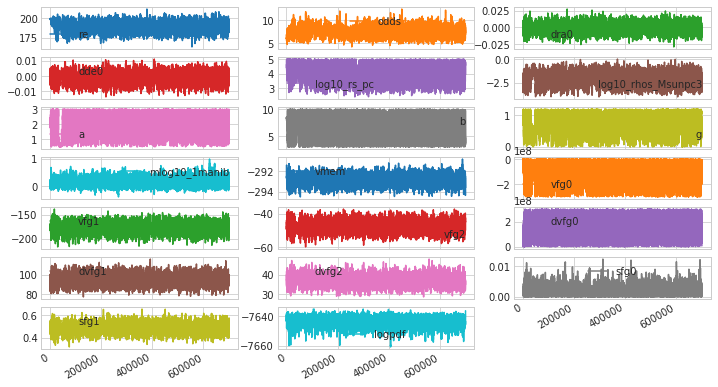

In [189]:
df[:].plot(subplots=True,layout=(8,3),figsize=(12,8))

In [49]:
df[::10].hist(bins=64,layout=(8,4),figsize=(12,16))

NameError: name 'df' is not defined

,re,odds,dra0,dde0,log10_rs_pc,log10_rhos_Msunpc3,a,b,g,mlog10_1manib,vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2,sfg0,sfg1,logpdf
re,1.000000,-0.638452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
odds,-0.638452,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dra0,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.166201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dde0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log10_rs_pc,NaN,NaN,NaN,NaN,1.000000,-0.725094,-0.187621,0.103906,0.212105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log10_rhos_Msunpc3,NaN,NaN,NaN,NaN,-0.725094,1.000000,NaN,NaN,-0.776633,0.348555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.113764
a,NaN,NaN,NaN,NaN,-0.187621,NaN,1.000000,NaN,0.154656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
b,NaN,NaN,NaN,NaN,0.103906,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
g,NaN,NaN,NaN,NaN,0.212105,-0.776633,0.154656,NaN,1.000000,-0.659788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.140487
mlog10_1manib,NaN,NaN,-0.166201,NaN,NaN,0.348555,NaN,NaN,-0.659788,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.180669


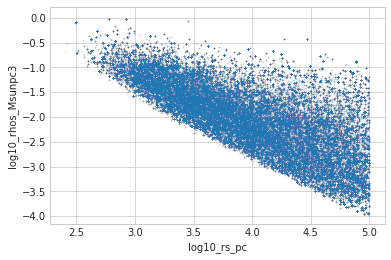

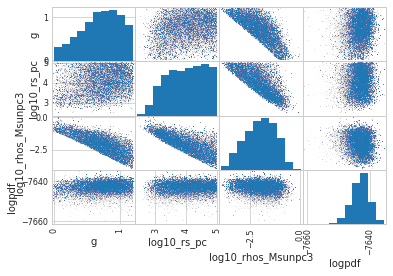

In [146]:
df.plot.scatter("log10_rs_pc","log10_rhos_Msunpc3",s=1,alpha=0.01)
#df.plot.scatter("log10_rs_pc","logpdf",s=1,alpha=0.01,ylim=[-7640,-7635])
#df.plot.scatter("b","logpdf",s=1,alpha=0.01,ylim=[-7640,-7635])
pd.plotting.scatter_matrix(df[["g","log10_rs_pc","log10_rhos_Msunpc3","logpdf"]],s=1,alpha=0.01)
df.corr()[np.abs(df.corr())>0.1]

In [ ]:
gen.options["push_time"] = 30
gen.generate(200000)

## results

In [105]:
result_df = gen.to_DataFrame()
#resultlog_df = gen.to_DataFrame(output_log=True)
#resultlog_df

if you already done the calculation, load the result below.

In [ ]:
#result_df = pd.read_csv("MCMCresult/MCMC_refR-re-w-center_v001.csv")
#resultlog_df = pd.read_csv("MCMCresult/MCMClog_refR-re-w-center_v001.csv")

In [73]:
ploted_stepset = 1
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
#result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

AttributeError: 'DataFrame' object has no attribute 'iter_num'

In [ ]:
mypairplot(result_df[-last_MCMC_steps::50])
#mypairplot(result_df[-lastMCMCsteps])

In [109]:
last_MCMC_steps = 200000
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

,re,odds,dra0,dde0,log10_rs_pc,log10_rhos_Msunpc3,a,b,g,mlog10_1manib,vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2,sfg0,sfg1,logpdf
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,188.137883,7.598996,-0.000229,-0.001409,3.994178,-2.042836,1.830047,6.381247,0.707114,0.142450,-292.857904,-8.889518e+07,-177.470099,-47.226358,1.281190e+08,94.496254,36.921645,0.002180,0.489103,-7642.684828
std,5.372065,1.012546,0.006732,0.003277,0.614413,0.775017,0.682310,1.983562,0.300879,0.144171,0.420385,8.244957e+07,9.375997,2.897717,8.643491e+07,4.618821,2.377803,0.001799,0.037951,3.105313
min,167.629480,4.162622,-0.025555,-0.013559,2.407135,-3.966075,0.516943,3.001170,0.001458,-0.402851,-294.393366,-2.995867e+08,-210.243135,-58.595984,1.924445e+04,77.523724,28.905824,0.000002,0.360221,-7659.782185
16%,182.968513,6.603586,-0.007099,-0.004706,3.288672,-2.924294,1.039881,4.048005,0.366527,0.003957,-293.269382,-1.846669e+08,-186.725327,-50.058005,2.859714e+07,89.932980,34.633822,0.000609,0.452406,-7645.678627
50%,187.970099,7.561568,-0.000245,-0.001366,4.028340,-2.022903,1.841995,6.283647,0.728248,0.129716,-292.872960,-6.284425e+07,-177.040420,-47.255614,1.207288e+08,94.207579,36.852454,0.001653,0.488723,-7642.484739
84%,193.576964,8.526456,0.006642,0.001947,4.677730,-1.196789,2.631638,8.672738,1.029828,0.281176,-292.408063,-9.999661e+06,-168.414533,-44.478224,2.317714e+08,98.995718,39.293552,0.003877,0.525753,-7639.822086
max,207.223211,11.998508,0.027519,0.010623,4.999939,-0.034607,2.999188,9.999800,1.199620,0.711882,-291.444300,-1.930374e+04,-142.224100,-37.087936,2.999119e+08,112.305598,46.059066,0.011276,0.654239,-7635.227608


In [111]:
plots_likelis = pd.DataFrame()
#plots_likelis["R"] = Rs # ideally loglikeli.R but approzimately here we use Rs
plots_likelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"])
plots_likelis["prob"] = np.exp(np.log(2*np.pi*plots_likelis.R)+loglikeli.loglikelis(**(stats[["re","odds","dra0","dde0"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis[::].plot(x="R",y="prob",ax=ax,figsize=(12,6))
display(plots_likelis[::].hist("R",bins=32,density=True,alpha=0.3,ax=ax))

TypeError: loglikelis() missing 15 required positional arguments: 'log10_rs_pc', 'log10_rhos_Msunpc3', 'a', 'b', 'g', 'mlog10_1manib', 'vmem', 'vfg0', 'vfg1', 'vfg2', 'dvfg0', 'dvfg1', 'dvfg2', 'sfg0', and 'sfg1'

In [ ]:
plots_loglikelis = pd.DataFrame()
plots_loglikelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"]) # ideally loglikeli.R but approzimately here we use Rs
plots_loglikelis["loglikeli"] = loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"]))
plots_loglikelis = plots_loglikelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_loglikelis[::].plot(x="R",y="loglikeli",ax=ax,figsize=(12,6))

## export

In [154]:
SPECIFY_NAME = "spectroscopy_sig_refR-re-w-center_plummer_Rsig-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v002"
result_df = df
result_df.to_csv(FNAME_BASE.format("",SPECIFY_NAME,VERSION),index=None)
resultlog_df.to_csv(FNAME_BASE.format("log",SPECIFY_NAME,VERSION),index=None)

# WBIC calculation

In [ ]:
#update likelihood
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs,beta=1):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            return np.sum(self.loglikelis(re,odds,dra0,dde0))
    def loglikelis(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return self.beta * ret


In [ ]:
loglikeli_wbic = KI17_loglikelihood_mod(dRAs=df_deg.x,dDEs=df_deg.y,beta=1/np.log(len(df_deg)))

In [ ]:
gen_wbic = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"n":0.8,"odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"n":0.1,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli_wbic
)

In [ ]:
gen_wbic.generate(5000)

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate_tuned((5000,5000,5000))

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate(100000)

In [ ]:
df_wbic = gen_wbic.to_DataFrame()[-100000:]
df_wbiclog = gen_wbic.to_DataFrame(output_log=True)
mypairplot(df_wbic[::20])

In [ ]:
wbic = -df_wbic.logpdf.mean()/loglikeli_wbic.beta
bic = -gen.to_DataFrame()[-100000:].logpdf.max() + len(gen.args_logpdf_init)/loglikeli_wbic.beta /2
print(" BIC:{}\nWBIC:{}".format(bic,wbic))

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME+"_wbic"
version = VERSION
df_wbic.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)